# Natural Computing

## Exercises on Evolutionary Computation

In [1]:
import tsplib95 # pip install tsplib95
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from operator import itemgetter
%matplotlib inline

### Exercise 6

In [2]:
tsp_problem_path = 'data/berlin52.tsp'
tsp_solution_path = 'data/berlin52.opt.tour'

In [3]:
# TSP problem information
problem = tsplib95.load_problem(tsp_problem_path)
print("--- TSP problem information ---")
print("Name: ", problem.name)
print("Comment: ", problem.comment)
print("Dimension: ", problem.dimension)
print("Edge weight type: ", problem.edge_weight_type)

--- TSP problem information ---
Name:  berlin52
Comment:  52 locations in Berlin (Groetschel)
Dimension:  52
Edge weight type:  EUC_2D


In [4]:
solution = tsplib95.load_solution(tsp_solution_path)
print("Optimal solution: ", problem.trace_tours(solution)[0])

Optimal solution:  7542


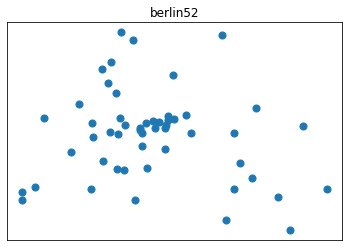

In [5]:
# Visualize TSP without edges
nx.draw_networkx_nodes(problem.get_graph(), problem.node_coords, node_size=50)
plt.title(f"{problem.name}")
plt.show()

#### Simple EA for TSP:
- Random initialization of the population
- Binary tournament selection (results in mating pool)
- Generational gap replacement strategy (10% elitism: 10% of worst offspring replaced by best current parents)
- Fixed size population

In [6]:
# Fitness function
def total_distance(tour, problem):
    total_dist = 0
    for i in range(len(tour)-1):
        a, b = tour[i], tour[i+1]
        dist = problem.wfunc(a, b)
        total_dist += dist
    return total_dist

In [7]:
# Binary tournament selection
def tournament(population):
    participants = random.sample(population, 2)
    winner = min(participants, key=itemgetter(1))
    return winner

In [8]:
# Get best and worst tour, and average tour distance in population
def population_stats(population):
    best = min(population, key=itemgetter(1))
    worst = max(population, key=itemgetter(1))
    avg = np.mean([tour[1] for tour in population])
    return best, worst, avg

In [9]:
# List of tuples representing edges for plotting
def get_edge_list(tour):
    edge_list = []
    for i in range(len(tour)-1):
        a, b = tour[i], tour[i+1]
        edge_list.append( (a, b) )
    return edge_list

In [10]:
# Plot tour including performance
def plot_tour(tour, distance, problem):
    edge_list = get_edge_list(tour)
    nx.draw_networkx(problem.get_graph(), 
                     pos=problem.node_coords, 
                     edgelist=edge_list, 
                     node_size=50,
                     with_labels=False
                    )
    plt.title(f"{problem.name} ({distance})")
    plt.show()

C:\Users\Richard\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


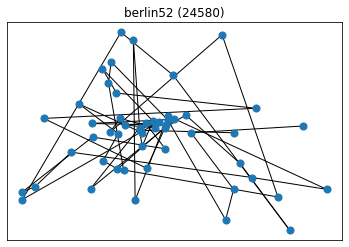

Best:  24580
Worst:  32536
Average:  29142.63


In [11]:
# paramter settings
p_c = 0.9 # probability of crossover
p_m = 0.2 # probability of mutation
size = 100 # population size
nr_of_generations = 1 # increase when EA is completely implemented

# Random initialization of population
nodes = list(problem.get_nodes())
population = [np.random.permutation(nodes) for _ in range(size)]
population = [(tour, total_distance(tour, problem)) for tour in population] # tuple(tour, distance)

best, worst, avg = population_stats(population)
plot_tour(best[0], best[1], problem) # best tour in initial population
print("Best: ", best[1])
print("Worst: ", worst[1])
print("Average: ", avg)

Note that for ordered-crossover only the order matters not the position.

In [53]:
def ordered_crossover(parent1, parent2):
    # choose two cut points
    length = len(parent1)
    pos1, pos2 = random.sample(range(length), 2)
    start_pos = min(pos1, pos2)
    end_pos = max(pos1, pos2)
    
    # slice between cut points
    child1 = parent1[start_pos:end_pos+1]
    child2 = parent2[start_pos:end_pos+1]
    
    # fill missing cities in order they appear in other parent
    missing_cities1 = [city for city in parent2 if city not in child1]
    missing_cities2 = [city for city in parent1 if city not in child2]
    
    # append missing cities starting from 2nd cut point
    child1 += missing_cities1
    child2 += missing_cities2
    return child1, child2

In [81]:
def mutation(tour):
    # shallow copy of original
    mutated_tour = tour[:]
    
    # choose two positions
    length = len(tour)
    pos1, pos2 = random.sample(range(length), 2)
    
    # reverse sequence mutation
    mutated_tour[pos1], mutated_tour[pos2] = mutated_tour[pos2], mutated_tour[pos1]
    return mutated_tour

In [84]:
# testing some functions
np.random.seed(42)
p1 = list(np.random.permutation(np.arange(10)))
p2 = list(np.random.permutation(np.arange(10)))
print(p1)
print(p2)
c1, c2 = ordered_crossover(p1, p2)
print(c1)
print(mutation(c1))
print(c1)
print(p1, p2)

[8, 1, 5, 0, 7, 2, 9, 4, 3, 6]
[0, 1, 8, 5, 3, 4, 7, 9, 6, 2]
[2, 9, 4, 0, 1, 8, 5, 3, 7, 6]
[2, 9, 4, 0, 1, 8, 5, 7, 3, 6]
[2, 9, 4, 0, 1, 8, 5, 3, 7, 6]
[8, 1, 5, 0, 7, 2, 9, 4, 3, 6] [0, 1, 8, 5, 3, 4, 7, 9, 6, 2]


In [ ]:
def EA_TSP(problem, size=100, nr_of_generations=200, p_c=0.9, p_m=0.2):
    population = init_population(problem, size)
    for t in range(nr_of_generations):
        new_population = []
        mating_pool = [tournament(population) for _ in range(size)]
         
        while new_population < size:
            # select two parents from mating pool
            parent1, parent2 = random.sample(mating_pool, 2) 
            # initalize offspring to be equal to parent
            child1, child2 = parent1[:], parent2[:]

            # ordered crossover
            test_p_c = np.random.uniform()
            if test_p_c < p_c:
                child1, child2 = ordered_crossover(parent1, parent2, p_c)
                
            # mutation
            test_p_m = np.random.uniform()
            if test_p_m < p_m:
                child1, child2 = mutation(child1), mutation(child2)
            
            # add offspring to new population
            new_population += [child1, child2]
                
    # elitism
    # evaluate population